In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.stats.weightstats import ttest_ind

plt.style.use('ggplot')

# Cleaning the data

dataset = pd.read_excel("mas_car_00_18_2019_adjusted.xlsx")

df = dataset[['Date Announced', 'Original Date Announced', 'Standard Industry Classification Code',
            'Same_industry', 'CAR(-1, +1)', 'CAR(-2, 2)', 'crossborderdeal', 'cashpayment', 'leverage',
            'Acquiror Market Value 4 Weeks Prior to Announcement ($mil).1', 'Deal Attitude', 'Deal Status',
            'Percentage of Shares Acquired', 'TPUBLIC', 'Target Market Value 4 Weeks Prior to Announcment ($mil)']]
df['Date (years)'] = pd.to_datetime(df['Date Announced'], format="%Y%m%d").dt.year

# rename the columns
column_mapping = {'Standard Industry Classification Code': 'SIC',
            'Same_industry': 'HORIZ', 'CAR(-2, 2)': 'CAR(-2, +2)',
            'crossborderdeal': 'CROSS', 'cashpayment': 'CASH', 'leverage': 'LEV',
            'Acquiror Market Value 4 Weeks Prior to Announcement ($mil).1': 'Acq_size',
            'TPUBLIC': 'Tar. Private', 'Target Market Value 4 Weeks Prior to Announcment ($mil)': 'DSIZE'}

df = df.rename(mapper=column_mapping, axis=1)

# drop date announced, original date announced
df = df.drop(['Date Announced', 'Original Date Announced'], axis=1)

# save new dataframe as a .csv file
df.to_csv('ARP_compressed_dataset.csv', index=False)

for col in dataset.columns:
    print(col)

# Conducting empirical analysis

In [8]:
# reimport the data set
df = pd.read_csv('ARP_compressed_dataset.csv')
df

,SIC,HORIZ,"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,LEV,Acq_size,Deal Attitude,Deal Status,Percentage of Shares Acquired,Tar. Private,DSIZE,Date (years)
0,5961,0,-0.001608,0.009858,0,0,0.456346,140.433,Friendly,Completed,36,Priv.,NaN,2013
1,5961,0,-0.018310,-0.034374,1,1,0.4521884,555.630,Friendly,Completed,100,Priv.,NaN,2008
2,5961,0,-0.007620,-0.015071,1,1,0.344419,426.282,Friendly,Completed,100,Sub.,NaN,2006
3,5961,0,0.211841,0.146537,1,1,0.3044112,330.046,Friendly,Completed,100,Public,137.544,2014
4,6020,0,0.001937,0.048450,1,0,0.9189009,57.730,Friendly,Completed,100,Priv.,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20371,6211,1,0.027444,0.020493,1,0,0.7598003,1333.872,Friendly,Pending,.,Sub.,NaN,2008
20372,6211,0,0.100135,0.151409,1,0,0.7244874,667.857,Friendly,Completed,100,Priv.,NaN,2009
20373,6211,0,0.039568,0.030297,1,0,0.7128826,1446.661,Friendly,Completed,100,Priv.,NaN,2007
20374,7372,0,-0.029043,0.003318,1,0,0.295371,355.064,Friendly,Completed,100,Priv.,NaN,2006


In [9]:
# categorise deals in terms of deal attitude
# remove deal attitude that is not applicable and unsolicit
df = df.loc[df['Deal Attitude'] != 'Not Appl.']
df = df.loc[df['Deal Attitude'] != 'Unsolic.']

# assign 1 to friendly deals and 0 to other deals
df.loc[:, 'Deal Attitude'].replace(to_replace={'Friendly': 1, 'Neutral': 0, 'Hostile': 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [10]:
# assign 1 to private targets and 0 to other public status
df.loc[:, 'Tar. Private'].replace(to_replace={'Priv.': 1, 'Sub.': 0, 'Public': 0, 'J.V.': 0, 'Govt.': 0}, inplace=True)
df.reset_index(inplace=True, drop=True)

In [11]:
# convert data in acquired ownership into float
df = df[df['Percentage of Shares Acquired'] != '.']
df['Percentage of Shares Acquired'] = df['Percentage of Shares Acquired'].astype(np.float64)

In [12]:
# only select the completed deals
df = df.loc[df['Deal Status'] == 'Completed']
print(f"The number of observations is: {df.shape[0]}")

# only select the deals that over 50% ownership is acquired
df = df.loc[df['Percentage of Shares Acquired'] >= 50]
print(f"The number of observations is: {df.shape[0]}")

# only select the deals with non-null target market value
df = df.loc[df['DSIZE'].notnull()]
print(f"The number of observations is: {df.shape[0]}")

# drop these two columns
df.drop(columns=['Deal Status', 'Percentage of Shares Acquired'], inplace=True)

The number of observations is: 16871
The number of observations is: 16086
The number of observations is: 1227


In [13]:
# categorise high-tech companies in terms of the SIC code
# 3-digit optimal SIC code in Kile and Phillips (2009)
df['SIC'] = df['SIC'].astype(str)

high_tech_sic = [283, 357, 366, 367, 382, 384, 481, 482, 489, 737, 873]
ht_df = pd.DataFrame()

for sic in high_tech_sic:    
    ht_df = pd.concat([ht_df, df[df['SIC'].str.startswith(f'{sic}')]])

ht_df.reset_index(inplace=True, drop=True)

In [14]:
# only select the deals from 2006 to 2017
ht_df = ht_df.loc[(ht_df['Date (years)'] >= 2005) & (ht_df['Date (years)'] <= 2017)]

# delete unnecessary columns (SIC, Date)
ht_df = ht_df.drop(['SIC', 'Deal Attitude'], axis=1)

# reset the index
ht_df = ht_df.reset_index(drop=True)

In [15]:
# change the dtype of column 'LEV'
ht_df = ht_df.drop(ht_df.loc[ht_df['LEV'] == '.'].index)
ht_df['LEV'] = ht_df['LEV'].astype(float)
ht_df = ht_df.reset_index(drop=True)

In [16]:
# calculate the relative size of each transaction
ht_df['RSIZE'] = ht_df['DSIZE'] / ht_df['Acq_size']

In [17]:
# reorder the column
ht_df = ht_df[[
    'Date (years)', 'CAR(-1, +1)', 'CAR(-2, +2)', 'CROSS', 'CASH',
    'HORIZ', 'DSIZE', 'RSIZE', 'LEV', 'Acq_size', 'Tar. Private'
    ]]

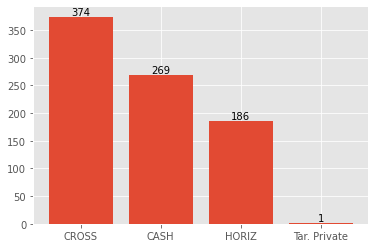

In [18]:
# visualise the distribution of categorical variables
x = ['CROSS', 'CASH', 'HORIZ', 'Tar. Private']
y = [ht_df[n].sum() for n in x]

plt.bar(x, y)
for i in range(len(y)):
    plt.annotate(str(y[i]), xy=(x[i], y[i]), ha='center', va='bottom')

plt.show()

In [19]:
# remove the Tar. private column
ht_df = ht_df.drop('Tar. Private', axis=1)

# reset the index
ht_df = ht_df.reset_index(drop=True)

In [20]:
ht_df.to_csv('ARP_ht_data.csv', index=False)
ht_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
0,2015,-0.059092,-0.068087,1,1,0,12573.957,0.138620,0.936763,90708.104
1,2009,0.004792,0.055386,1,1,0,335.825,0.004191,0.536660,80123.704
2,2014,-0.008882,0.011462,0,0,1,1765.680,0.030198,0.436201,58470.467
3,2010,0.018298,-0.007777,1,1,0,441.778,0.005342,0.563140,82693.787
4,2009,-0.002918,-0.009315,0,0,0,65.911,0.000795,0.571191,82951.559
...,...,...,...,...,...,...,...,...,...,...
447,2008,-0.014172,-0.030753,0,0,0,774.044,0.024593,0.242955,31473.649
448,2007,0.010579,0.018269,1,0,0,25.564,0.043071,0.693630,593.531
449,2006,-0.059281,-0.080870,1,1,0,30.412,0.053428,0.603128,569.210
450,2006,0.024441,0.032589,1,1,0,1.651,0.024208,0.645392,68.202


# Empirical analysis
- Univariate test
- Multivariate test

## Univariate test

In [21]:
# t-test for cross-border and domestic samples
cross = ht_df['CAR(-1, +1)'].loc[ht_df['CROSS'] == 1]
domestic = ht_df['CAR(-1, +1)'].loc[ht_df['CROSS'] == 0]
one_day_car_cross = ttest_ind(x1=cross, x2=domestic, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cross[0]:.3f}
    The p-value is: {one_day_car_cross[1] / 2:.3f}
    The degree of freedom is {one_day_car_cross[2]:.3f}
    """)


    The t-statistics is: -2.666
    The p-value is: 0.004
    The degree of freedom is 120.824
    


In [22]:
cross = ht_df['CAR(-2, +2)'].loc[ht_df['CROSS'] == 1]
domestic = ht_df['CAR(-2, +2)'].loc[ht_df['CROSS'] == 0]
two_day_car_cross = ttest_ind(x1=cross, x2=domestic, usevar='unequal')

print(f"""
    The t-statistics is: {two_day_car_cross[0]:.3f}
    The p-value is: {two_day_car_cross[1] / 2:.3f}
    The degree of freedom is {two_day_car_cross[2]:.3f}""")


    The t-statistics is: -2.430
    The p-value is: 0.008
    The degree of freedom is 114.575


In [23]:
# t-test for cash and non-cash observations
cash = ht_df['CAR(-1, +1)'].loc[ht_df['CASH'] == 1]
non_cash = ht_df['CAR(-1, +1)'].loc[ht_df['CASH'] == 0]
one_day_car_cash = ttest_ind(x1=cash, x2=non_cash, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cash[0]:.3f}
    The p-value is: {one_day_car_cash[1] / 2:.3f}
    The degree of freedom is {one_day_car_cash[2]:.3f}""")


    The t-statistics is: 2.015
    The p-value is: 0.022
    The degree of freedom is 256.145


In [24]:
cash = ht_df['CAR(-2, +2)'].loc[ht_df['CASH'] == 1]
non_cash = ht_df['CAR(-2, +2)'].loc[ht_df['CASH'] == 0]
two_day_car_cash = ttest_ind(x1=cash, x2=non_cash, usevar='unequal')

print(f"""
    The t-statistics is: {one_day_car_cash[0]:.3f}
    The p-value is: {one_day_car_cash[1] / 2:.3f}
    The degree of freedom is {one_day_car_cash[2]:.3f}""")


    The t-statistics is: 2.015
    The p-value is: 0.022
    The degree of freedom is 256.145


## Mutivariate test

In [31]:
# descriptive statistics of the sample
descriptive_df = ht_df.describe()

# save the table
descriptive_df.to_csv('tables_for_use/descriptive_statistics.csv')

descriptive_df

,Date (years),"CAR(-1, +1)","CAR(-2, +2)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000
mean,2010.194690,-0.003361,-0.004979,0.827434,0.595133,0.411504,1358.432938,0.451145,0.468803,30941.265316
std,3.073695,0.072058,0.082718,0.378291,0.491410,0.492651,3991.606474,5.439938,0.256008,58080.852429
min,2005.000000,-0.330750,-0.368057,0.000000,0.000000,0.000000,0.041000,0.000011,0.034233,1.758000
25%,2008.000000,-0.028850,-0.032935,1.000000,0.000000,0.000000,66.026500,0.015947,0.301691,845.741250
50%,2010.000000,-0.002362,-0.003933,1.000000,1.000000,0.000000,271.021500,0.068305,0.455397,4178.331000
75%,2013.000000,0.023812,0.027444,1.000000,1.000000,1.000000,994.178000,0.220401,0.594697,29155.445000
max,2016.000000,0.270624,0.315561,1.000000,1.000000,1.000000,48119.939000,115.630830,2.758185,547445.100000


In [32]:
# correlation matirx of the sample
correlation_df = ht_df.drop(['CAR(-2, +2)', 'Date (years)'], axis=1).corr()

# save the table
correlation_df.to_csv('tables_for_use/correlation.csv')

correlation_df

,"CAR(-1, +1)",CROSS,CASH,HORIZ,DSIZE,RSIZE,LEV,Acq_size
"CAR(-1, +1)",1.000000,-0.115914,0.104763,0.133021,0.019609,-0.086554,-0.011162,0.026351
CROSS,-0.115914,1.000000,-0.018841,0.132031,0.064479,0.024022,0.051917,0.076035
CASH,0.104763,-0.018841,1.000000,-0.042998,-0.132312,-0.078159,-0.074334,0.232984
HORIZ,0.133021,0.132031,-0.042998,1.000000,0.108663,-0.040476,-0.003052,-0.063447
DSIZE,0.019609,0.064479,-0.132312,0.108663,1.000000,-0.000974,0.060007,0.184530
RSIZE,-0.086554,0.024022,-0.078159,-0.040476,-0.000974,1.000000,-0.016261,-0.039969
LEV,-0.011162,0.051917,-0.074334,-0.003052,0.060007,-0.016261,1.000000,0.106802
Acq_size,0.026351,0.076035,0.232984,-0.063447,0.184530,-0.039969,0.106802,1.000000


In [27]:
# multilinear regression of 1-day CAR
y = ht_df['CAR(-1, +1)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-1, +1)   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3.569
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           0.000953
Time:                        16:44:40   Log-Likelihood:                 560.40
No. Observations:                 452   AIC:                            -1105.
Df Residuals:                     444   BIC:                            -1072.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.011     -0.078      0.938      -0.023       0.021
CROSS         -0.0257      0.009     -2.878      0.004      -0.043      -0.008
CASH           0.0151      0.007      2.111      0.035       0.001       0.029
HORIZ          0.0221      0.007      3.206      0.001       0.009       0.036
DSIZE       4.081e-07    8.7e-07      0.469      0.639    -1.3e-06    2.12e-06
RSIZE         -0.0009      0.001     -1.477      0.140      -0.002       0.000
LEV        -4.792e-05      0.013     -0.004      0.997      -0.026       0.026
Acq_size    1.905e-08   6.13e-08      0.311      0.756   -1.01e-07    1.39e-07
==============================================================================
Omnibus:                       50.759   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              330.983
Skew:                           0.111   Prob(JB):                     1.34e-72
Kurtosis:                       7.186   Cond. No.                     3.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# multilinear regression of 2-day CAR
y = ht_df['CAR(-2, +2)']
X = ht_df.drop(['CAR(-1, +1)', 'CAR(-2, +2)', 'Date (years)'], axis=1)
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

results.summary()

/opt/homebrew/Caskroom/miniforge/base/envs/pyfinance/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            CAR(-2, +2)   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     3.625
Date:                Fri, 06 Aug 2021   Prob (F-statistic):           0.000818
Time:                        16:44:40   Log-Likelihood:                 498.23
No. Observations:                 452   AIC:                            -980.5
Df Residuals:                     444   BIC:                            -947.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.013      0.529      0.597      -0.018       0.032
CROSS         -0.0270      0.010     -2.634      0.009      -0.047      -0.007
CASH           0.0195      0.008      2.376      0.018       0.003       0.036
HORIZ          0.0243      0.008      3.069      0.002       0.009       0.040
DSIZE       1.116e-07   9.98e-07      0.112      0.911   -1.85e-06    2.07e-06
RSIZE         -0.0006      0.001     -0.867      0.386      -0.002       0.001
LEV           -0.0231      0.015     -1.532      0.126      -0.053       0.007
Acq_size    2.591e-10   7.03e-08      0.004      0.997   -1.38e-07    1.38e-07
==============================================================================
Omnibus:                       45.808   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.164
Skew:                          -0.244   Prob(JB):                     2.56e-48
Kurtosis:                       6.376   Cond. No.                     3.09e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""